# Exploratory Data Analysis

**“Guessing what the pitcher is going to throw is 80 percent of being a successful hitter. The other 20 percent is just execution.” -Hank Aaron.**

My objective is to utilize all of the situational pre-pitch information a batter has in order to predict the next most likely pitch. In this section I will explore all of the data a pitcher has pre-pitch and explore their relationships/ distributions. 

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import random
import warnings

from numba import prange
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

In [137]:
random.seed(16)

In [138]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### Loading in Statcast Data

Due to the large file size, I uploaded all of my data to an s3 bucket. 

In [139]:
# Specifying s3 as boto3 resource and connecting to bucket
s3 = boto3.resource('s3')
bucketname = 'baseballstats'

# Name of files within the bucket
statcast_stats_2018 = 'statcast_data/sc_2018.csv'
statcast_stats_2019 = 'statcast_data/sc_2019.csv'

# Specifying location of files
statcast_obj_2018 = s3.Object(bucketname, statcast_stats_2018)
statcast_obj_2019 = s3.Object(bucketname, statcast_stats_2019)

# Getting the body of the files
statcast_2018 = statcast_obj_2018.get()['Body']
statcast_2019 = statcast_obj_2019.get()['Body']

In [140]:
# Reading the boto3 object into a csv

# df is my default for the statcast 2019 season
df = pd.read_csv(statcast_2019)

# sc_2018 is utilized in my feature engineering and cleaning function
sc_2018 = pd.read_csv(statcast_2018)

In [141]:
# When uploading files, I forgot to specify index=False
df = df.drop(columns=['index'])

In [142]:
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,SL,2019-10-30,87.9,-2.65,5.50,Daniel Hudson,488726.0,543339.0,strikeout,swinging_strike,NaN,NaN,NaN,NaN,14.0,Michael Brantley strikes out swinging.,W,L,R,HOU,WSH,S,2.0,NaN,3.0,2.0,2019.0,0.02,0.21,0.88,1.03,NaN,NaN,NaN,2.0,9.0,Bot,NaN,NaN,NaN,NaN,543228.0,NaN,191031_035012,8.472927,-127.797998,-5.181622,-1.384471,23.932114,-29.091156,3.35,1.40,NaN,NaN,NaN,87.8,2461.0,6.1,599377.0,543339.0,543228.0,475582.0,452678.0,543685.0,607208.0,665742.0,645302.0,594809.0,54.42,NaN,NaN,0.0,1.0,0.0,0.0,NaN,79.0,7.0,Slider,2.0,6.0,2.0,6.0,6.0,2.0,2.0,6.0,Infield shift,Standard
1,FF,2019-10-30,95.9,-2.77,5.52,Daniel Hudson,488726.0,543339.0,NaN,foul,NaN,NaN,NaN,NaN,7.0,NaN,W,L,R,HOU,WSH,S,NaN,NaN,3.0,2.0,2019.0,-0.57,1.52,-0.47,1.92,NaN,NaN,NaN,2.0,9.0,Bot,NaN,NaN,NaN,NaN,543228.0,NaN,191031_034945,7.236909,-139.212420,-7.101361,-8.940442,32.683954,-11.563514,3.35,1.56,277.0,NaN,NaN,94.4,2572.0,5.7,599377.0,543339.0,543228.0,475582.0,452678.0,543685.0,607208.0,665742.0,645302.0,594809.0,54.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,6.0,4-Seam Fastball,2.0,6.0,2.0,6.0,6.0,2.0,2.0,6.0,Infield shift,Standard
2,FF,2019-10-30,96.5,-2.68,5.42,Daniel Hudson,488726.0,543339.0,NaN,ball,NaN,NaN,NaN,NaN,14.0,NaN,W,L,R,HOU,WSH,B,NaN,NaN,2.0,2.0,2019.0,-0.66,1.40,1.68,1.35,NaN,NaN,NaN,2.0,9.0,Bot,NaN,NaN,NaN,NaN,543228.0,NaN,191031_034912,12.923798,-139.703293,-8.230555,-11.485524,32.459653,-12.442450,3.53,1.63,NaN,NaN,NaN,95.3,2637.0,5.9,599377.0,543339.0,543228.0,475582.0,452678.0,543685.0,607208.0,665742.0,645302.0,594809.0,54.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,5.0,4-Seam Fastball,2.0,6.0,2.0,6.0,6.0,2.0,2.0,6.0,Infield shift,Standard
3,FF,2019-10-30,96.0,-2.65,5.55,Daniel Hudson,488726.0,543339.0,NaN,foul,NaN,NaN,NaN,NaN,9.0,NaN,W,L,R,HOU,WSH,S,NaN,NaN,2.0,1.0,2019.0,-0.81,1.50,0.75,2.05,NaN,NaN,NaN,2.0,9.0,Bot,NaN,NaN,NaN,NaN,543228.0,NaN,191031_034840,10.686962,-139.133193,-6.897620,-12.790017,31.422309,-11.667275,3.35,1.56,382.0,NaN,NaN,94.9,2598.0,5.9,599377.0,543339.0,543228.0,475582.0,452678.0,543685.0,607208.0,665742.0,645302.0,594809.0,54.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,4.0,4-Seam Fastball,2.0,6.0,2.0,6.0,6.0,2.0,2.0,6.0,Infield shift,Standard
4,SL,2019-10-30,86.7,-2.73,5.59,Daniel Hudson,488726.0,543339.0,NaN,ball,NaN,NaN,NaN,NaN,14.0,NaN,W,L,R,HOU,WSH,B,NaN,NaN,1.0,1.0,2019.0,-0.05,0.47,1.27,2.17,NaN,NaN,NaN,2.0,9.0,Bot,NaN,NaN,NaN,NaN,543228.0,NaN,191031_034810,9.633513,-126.044028,-2.982919,-2.223969,21.921075,-26.826688,3.59,1.63,NaN,NaN,NaN,87.0,2598.0,6.2,599377.0,543339.0,543228.0,475582.0,452678.0,543685.0,607208.0,665742.0,645302.0,594809.0,54.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,3.0,Slider,2.0,6.0,2.0,6.0,6.0,2.0,2.0,6.0,Infield shift,Standard


In [143]:
df.shape

(743572, 89)

In [144]:
# Dropping deprecated columns

def columns_to_drop(df):

    '''
    Drops columns that were deprecated during the transition to new statcast
    hardware and thus null in every row. 
    ---
    Returns:
    type: DataFrame
        Composed of non-deprecated data. 
    
    ---
    Parameters:
    df
        Type: DataFrame. 
        Full statcast DataFrame.
    '''
    
    drop_columns = []
    
    # Storing columns whose null length is as long as the DataFrame
    for column in df.columns:
        if df[column].isna().sum() == len(df):
            drop_columns.append(column)
    
    return drop_columns

In [145]:
# Dropping columns stored by columns to drop function
df = df.drop(columns = columns_to_drop(df))

In [146]:
# New shape of DataFrame
df.shape

(743572, 82)

## What features describe the situation of the pitch?

Situational data is defined as data that defines what point in the game the pitch is occurring in. This model is meant to help hitter's prepare for a given situation based on the data readily available to them, therefore I remove most of the advanced statistics recorded by statcast. 

Some examples of situational data include how many runners are on base and where they are located, the number of outs when the batter is up, the count the hitter is facing, the pitch the hitter just saw previously, the sequence of pitches thrown to them over the course of the at-bat, the result of the previous at bat, the run-differential between the two teams, what type of event occurred in the previous pitch (ball, strike, or event where hitter either is out or makes it to the base), the number of pitches the batter has faced, and the alignment of the defense. 

In [147]:
# Situational columns identified from domain knowledge
pitch_columns = ['pitcher','batter', 'zone', 'pitch_number',
     'stand', 'p_throws', 'type',  'balls', 'strikes', 
      'on_3b', 'on_2b', 'on_1b','outs_when_up', 'inning', 
       'inning_topbot','woba_value', 'at_bat_number', 
       'pitch_name', 'bat_score', 'fld_score','if_fielding_alignment',
       'of_fielding_alignment','game_pk']

In [148]:
# Filtering DataFrame to only situational columns 
df_pitch = df[pitch_columns]

In [149]:
df_pitch.shape

(743572, 23)

In [150]:
# 4-seam fastball and 2-seam fastball initially type float 
df['pitch_name'] = df['pitch_name'].astype(str)

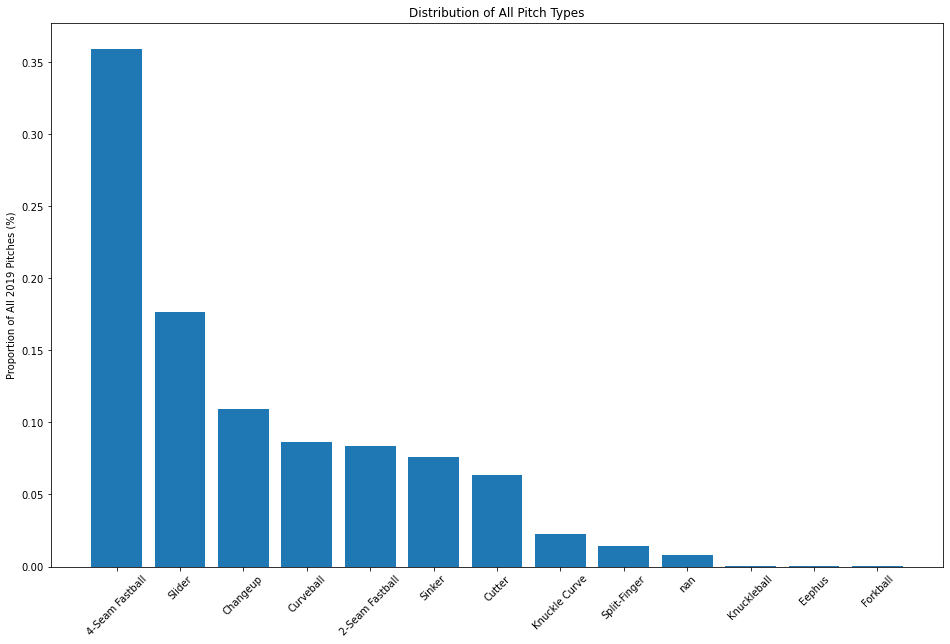

In [151]:
# Gathering pitch value counts 
pitch_value_counts = df['pitch_name'].value_counts(normalize=True)

plt.figure(figsize=(16, 10))

plt.bar(x=pitch_value_counts.index, height=pitch_value_counts)
plt.xticks(rotation=45)
plt.title('Distribution of All Pitch Types')
plt.ylabel('Proportion of All 2019 Pitches (%)');

In [152]:
# There is no zone 10
df['zone'].value_counts()

14.0    144601
13.0    100258
11.0     80617
12.0     60629
5.0      51787
8.0      46693
6.0      43468
4.0      42847
9.0      42177
7.0      36327
2.0      33673
1.0      28860
3.0      25878
Name: zone, dtype: int64

## Making the data more interpretable

In order to truly tease out the relationships between the selected features and the predicted pitch type, I need to one-hot-encode several variables and engineer several new features.

### How to prevent data leakage
In order to prevent data leakage, I only take into account data that occurs before the current pitch is thrown. Therefore, I have to manipulate the some of the data to measure the previous outcomes. I manipulate zone to only take into account the previous pitch, the previous zone, the previous type of outcome. I also engineer a feature that takes into account the previous hitter's outcome utilizing the woba_value feature. Woba is a statistic that weighs the value of the previous hitter's outcome, therefore I can use the value for the previous plate appearance to determine what the outcome of the previous batter's plate appearance was. 

### Future Improvement on Feature Engineering Function

* Learn how to reduce time complexity of these processes.
* Start with smaller chunks of total data to determine where errors in feature creation are occurring. 
    * Specifically want to look at the key errors and previous_hitter_woba inconsistencies
    * In retrospect, I would have created a feature that denoted if previous hitter was in the same half inning and facing the same pitcher rather than trying to create a new woba_value to denote that fact. 
* Break monolithic function into modular code. 
 

In [153]:
def df_by_year(df):
    
    # Setting the previous year's dataframe equal to the 2018 year
    previous_year = sc_2018

    # Columns to filter 2019 DataFrame on
    pitch_columns = ['pitcher','batter', 'zone', 'pitch_number',
     'stand', 'p_throws', 'type',  'balls', 'strikes', 
      'on_3b', 'on_2b', 'on_1b','outs_when_up', 'inning', 
       'inning_topbot','woba_value', 'at_bat_number', 
       'pitch_name', 'bat_score', 'fld_score','if_fielding_alignment',
       'of_fielding_alignment','game_pk']
    
    # Filtered 2019 DataFrame
    new_df = df[pitch_columns]
    
    
    # Label creation: Creating 3 labels for each type of pitch
    
    # Pitches that will be labeled 1
    change = ['Changeup', 'Split-Finger', 'Knuckleball', 'Eephus', 'Forkball', 
              'Screwball']
    
    # Pitches that will be labeled 2
    breaking = ['Curveball', 'Knuckle Curve', 'Slider']
    
    # Pitches that will be labeled 3
    fast = ['4-Seam Fastball', 'Fastball', 'Cutter', '2-Seam Fastball', 'Sinker']
    
    # Creating my target column titled pitch
    new_df['pitch'] = [1 if x in change else 2 if x in breaking else 3 for x in 
                       new_df[ 'pitch_name']]

    # Creating target column in 2018 statcast data 
    previous_year['pitch'] = [1 if x in change else 2 if x in breaking 
    else 3 for x in previous_year['pitch_name']]
    
    # Instantiating the pitch sequence columns
    new_df[1] = 0
    new_df[2] = 0
    new_df[3] = 0

    # To prevent leakage, utilizing pitch distribution from the previous year
    pitch_recorder = pd.get_dummies(data=previous_year, columns=['pitch'], 
                                    drop_first=True)[['pitcher','pitch_2', 
                                    'pitch_3']].set_index('pitcher')
    
    # Gathering proportion of each pitch type (target variable) each pitcher 
    # threw in 2018
    pitcher_type = pitch_recorder.groupby('pitcher').mean()
    
    # Merging 2019 DatFrame and 2018 pitcher_type DataFrame on the pitcher ID
    # Chose a left merge in order to preserve the order of the DataFrame 
    # if a pitcher did not pitch in 2018. These rows will be later be dropped. 
    new_df = new_df.merge(pitcher_type, on='pitcher', how='left')

    # Getting dummies for pitcher and batter dominant hand features
    new_df = pd.get_dummies(data=new_df, columns=['stand', 'p_throws'], drop_first=True)
    
    # Getting dummies of the defensive alignement 
    new_df = pd.get_dummies(data=new_df, columns=['if_fielding_alignment', 
                                                  'of_fielding_alignment'])
    
    # Choosing which columns to drop rather than dropping first dummy because
    # certain defensive alignments were significantly rarer
    new_df = new_df.drop(columns=['if_fielding_alignment_Strategic', 
                                'of_fielding_alignment_Strategic'])

    # Instantiating Runner in Scoring Position (risp) feature
    new_df['risp'] = 0
    
    # Instantiating previous pitch, zone, and play type features by setting
    # each instance equal to the previous observation
    new_df['previous_pitch'] = new_df['pitch'].shift(-1)

    new_df['previous_zone'] = new_df['zone'].shift(-1)

    new_df['previous_type'] = new_df['type'].shift(-1)
    
    # Determining the previous_hitter's at-bat outcome with the weighted on-base average (woba)
    # Assign woba value of -1 to values that do not meet conditions of being 
    new_df['previous_hitter_woba'] = -1

    # Resetting the index to account for pitcher merge disrupting DataFrame indexing 
    new_df.reset_index(drop=True, inplace=True)

    
    # The DataFrame is organized in descending order of time
    for i in prange(len(new_df)): 
        
        # Kept getting key errors on my iterations, so I included this if-statement
        # to account for erorrs. In future, need to do better due-diligence into
        # why key errors were occurring
        if (i+1) not in new_df.index.to_list():
            continue

        # Setting values for the last observation
        if i == (len(new_df) - 1):
            new_df.loc[i, 'previous_pitch'] = 0
            new_df.loc[i, 'previous_zone'] = 0
            # Ensures this feature is not included in the last observation.
            new_df.loc[i, 'previous_type'] = 'X'
            break
        
        # Creating variable to compare whether following observation is within same game
        game_comp = (new_df.loc[i, 'game_pk'] == new_df.loc[i+1, 'game_pk'])

        # Creating variable to compare whether following observation is within same at-bat
        same_hitter_comp = (new_df.loc[i, 'at_bat_number'] == new_df.loc[(i+1), 'at_bat_number'])
        
        # Creating variable to compare whether 
        pitcher_comp = new_df.loc[i, 'pitcher'] == new_df.loc[i+1, 'pitcher']
        half_inning_comp = new_df.loc[i, 'inning_topbot'] == new_df.loc[i+1, 'inning_topbot']
        inning_comp = new_df.loc[i, 'inning'] == new_df.loc[i+1, 'inning']

        # Ensuring that first pitch of at-bat is denoted with previous_pitch of 0
        if not game_comp & same_hitter_comp:
            new_df.loc[i, 'previous_pitch'] = 0
            new_df.loc[i, 'previous_zone'] = 0
            new_df.loc[i, 'previous_type'] = 'X'
            
        # Gathering previous hitter's at-bat result. The precious hitter has
        if game_comp & same_hitter_comp:
            
            # Iterating over the rest of the DataFrame to find previous hitter woba
            for y in range((i+1), len(new_df) -1):
                
                # Statement that finds the previous_hitter
                different_hitter_comp = (new_df.loc[i, 'at_bat_number'] != new_df.loc[y, 'at_bat_number'])
                
                # Previous hitter has to be in the same game, inning, half-inning,
                # and have the same pitcher throwing. 
                if different_hitter_comp & pitcher_comp & inning_comp & half_inning_comp:
                    new_df.loc[i, 'previous_hitter_woba'] = new_df.loc[y, 'woba_value']
                    break
                # If does not meet those conditions, it is assigned -1 value
                # because the woba is not indicative of the innings results
                else:
                    new_df.loc[i, 'previous_hitter_woba'] = -1
                    
        # If the next hitter is in the same game and innning, find the result of the 
        # previous at-bat.
        elif game_comp & inning_comp & half_inning_comp:
            new_df.loc[i, 'previous_hitter_woba'] = new_df.loc[(i+1), 'woba_value']

        # Encoding risp feature with 1 if there is a runner on 2nd or 3rd base
        if (new_df.loc[i, 'on_2b'] > 0) or (new_df.loc[i, 'on_3b'] > 0):
            new_df.loc[i, 'risp'] = 1
        
        # One hot encoding the on first base feature
        if (new_df.loc[i, 'on_1b'] > 0):
            new_df.loc[i,'on_1b'] = 1
        else: 
            new_df.loc[i,'on_1b'] = 0

        # Creating the ppitch sequence dictionary
        pitch_sequence = {}
        pitch_sequence[1] = 0
        pitch_sequence[2] = 0
        pitch_sequence[3] = 0

        # Creating variable to analyze the number of previous pitches that occurred 
        # during the at-bat
        current_at_bat = new_df.loc[i, 'at_bat_number'] 
        
        # Iterating over the all of the rows until previous at-bat reached. 
        # Recording the number of each type of pitch in the at-bat up to the
        # point the current pitch is thrown
        for y in range((i+1), len(new_df)-1):
            if new_df.loc[y, 'at_bat_number'] != current_at_bat:
                break
            pitch = new_df.loc[y, 'pitch']
            pitch_sequence[pitch] += 1

        # Recording the pitch types up to that point
        for pitch in pitch_sequence:
            new_df.loc[i, pitch] = pitch_sequence[pitch]

    # Filling null values in the previous_hitter_woba
    new_df['previous_hitter_woba'].fillna(-1, inplace=True)

    # Instantiating run differential feature from the perspective of pitcher
    new_df['run_diff'] = new_df['fld_score'] - new_df['bat_score']

    # Getting dummies for the half-inning feature
    new_df = pd.get_dummies(data=new_df, columns=['inning_topbot'], drop_first=True)

    # Getting dummies for the previous play type 
    new_df = pd.get_dummies(data=new_df, columns=['previous_type'])
    # Dropping play types that were previously hit (this information is captured
    # in the woba). Use play_type to determine if previous pitch was a strike or not
    new_df = new_df.drop(columns=['previous_type_X'])

    # Gathering information about current hitter's previous year
    sc_vc = previous_year['batter'].value_counts()
    # Only choosing hitters that had more than 500 pitches seen in 2018 season
    statcast_vet_hitter = sc_vc[sc_vc > 500].index.to_list()

    # Creating DataFrame of hitter's to merge on 
    train_merge = previous_year[previous_year['batter'].isin(statcast_vet_hitter)].groupby('batter')\
    [['woba_value', 'launch_speed']].mean()

    # Merging previous year's hitting information on 2019 DataFrame
    new_df = new_df.merge(train_merge, on='batter')
    
    # Dropping columns that do not convey information to the model that is
    # not captured by a feature already engineered. 
    new_df = new_df.drop(columns=['at_bat_number', 'bat_score', 'fld_score', 'type',
                    'game_pk', 'pitcher', 'on_2b', 'on_3b', 'zone',
                    'pitch_name', 'woba_value_x', 'batter', 'pitch_number'])

    # Renaming columns for easier identification
    new_df.rename(columns={1: 'changeup_in_sequence', 2:'breaking_ball_in_sequence', 
                           3: 'fastball_in_sequence', 'woba_value_y': 'hitter_woba_2018',
                          'pitch_3': 'proportion_of_fastballs_thrown_2018', 
                           'pitch_2': 'proportion_of_breaking_balls_thrown_2018',
                        'launch_speed': 'average_hitter_launch_speed_2018'}, inplace=True)
    
    
    return new_df

## Example for Feature Engineering Function Demonstration 

In [154]:
# Utilizing a single game to demonstrate the various operations of my function 
ex_df = df[df['game_pk'] == 599377.0]

In [155]:
example = df_by_year(ex_df)

In [156]:
example.head(30)

,balls,strikes,on_1b,outs_when_up,inning,pitch,changeup_in_sequence,breaking_ball_in_sequence,fastball_in_sequence,proportion_of_breaking_balls_thrown_2018,proportion_of_fastballs_thrown_2018,stand_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,of_fielding_alignment_Standard,risp,previous_pitch,previous_zone,previous_hitter_woba,run_diff,inning_topbot_Top,previous_type_B,previous_type_S,hitter_woba_2018,average_hitter_launch_speed_2018
0,3.0,2.0,0.0,2.0,9.0,2,0,1,5,0.396482,0.558863,0,1,1,0,1,0,3.0,7.0,0.0,4.0,0,0,1,0.366304,90.160819
1,3.0,2.0,0.0,2.0,9.0,3,0,1,4,0.396482,0.558863,0,1,1,0,1,0,3.0,14.0,0.0,4.0,0,1,0,0.366304,90.160819
2,2.0,2.0,0.0,2.0,9.0,3,0,1,3,0.396482,0.558863,0,1,1,0,1,0,3.0,9.0,0.0,4.0,0,0,1,0.366304,90.160819
3,2.0,1.0,0.0,2.0,9.0,3,0,1,2,0.396482,0.558863,0,1,1,0,1,0,2.0,14.0,0.0,4.0,0,1,0,0.366304,90.160819
4,1.0,1.0,0.0,2.0,9.0,2,0,0,2,0.396482,0.558863,0,1,1,0,1,0,3.0,7.0,0.0,4.0,0,0,1,0.366304,90.160819
5,1.0,0.0,0.0,2.0,9.0,3,0,0,1,0.396482,0.558863,0,1,1,0,1,0,3.0,14.0,0.0,4.0,0,1,0,0.366304,90.160819
6,0.0,0.0,0.0,2.0,9.0,3,0,0,0,0.396482,0.558863,0,1,1,0,1,0,0.0,0.0,0.0,4.0,0,0,0,0.366304,90.160819
7,3.0,1.0,0.0,0.0,7.0,3,0,2,2,0.502228,0.486314,0,0,1,0,1,0,2.0,13.0,0.0,1.0,0,1,0,0.366304,90.160819
8,2.0,1.0,0.0,0.0,7.0,2,0,1,2,0.502228,0.486314,0,0,1,0,1,0,3.0,9.0,0.0,1.0,0,0,1,0.366304,90.160819
9,2.0,0.0,0.0,0.0,7.0,3,0,1,1,0.502228,0.486314,0,0,1,0,1,0,2.0,13.0,0.0,1.0,0,1,0,0.366304,90.160819


**After iterating through the DataFrame in order, I merged the hitter results onto the DataFrame, which manipulated the index to no longer be in order of the game but by hitter. However, all of the information that was recorded previously is still capturing the order of the game.**

Walking through the hitter in the index positions 0-6, we can see that the pitch sequence count and the number of balls and strikes match up well. On top of that, we can see that other situational information such as runner's in scoring position (risp), run differential, hitter woba, proportion of each pitch thrown by the pitcher, and the inning all stay constant as they should. 

As you go down the first 30 rows, you can confirm that the function is behaving appropriately on the scale of a single game in the 2019 season. 

In [157]:
example.isnull().sum()

balls                                        0
strikes                                      0
on_1b                                        1
outs_when_up                                 0
inning                                       0
pitch                                        0
changeup_in_sequence                         0
breaking_ball_in_sequence                    0
fastball_in_sequence                         0
proportion_of_breaking_balls_thrown_2018    10
proportion_of_fastballs_thrown_2018         10
stand_R                                      0
p_throws_R                                   0
if_fielding_alignment_Infield shift          0
if_fielding_alignment_Standard               0
of_fielding_alignment_Standard               0
risp                                         0
previous_pitch                               1
previous_zone                                1
previous_hitter_woba                         0
run_diff                                     0
inning_topbot

In [158]:
# Previous zone is not being accounted for in the first pitch of the game
example[example['previous_zone'].isna()]

,balls,strikes,on_1b,outs_when_up,inning,pitch,changeup_in_sequence,breaking_ball_in_sequence,fastball_in_sequence,proportion_of_breaking_balls_thrown_2018,proportion_of_fastballs_thrown_2018,stand_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,of_fielding_alignment_Standard,risp,previous_pitch,previous_zone,previous_hitter_woba,run_diff,inning_topbot_Top,previous_type_B,previous_type_S,hitter_woba_2018,average_hitter_launch_speed_2018
139,0.0,0.0,NaN,0.0,1.0,3,0,0,0,0.281756,0.489103,1,1,0,1,1,0,NaN,NaN,-1.0,0.0,1,0,0,0.345867,89.032054


In [159]:
# Drop null values. Null values are caused by merging either the pitching or hitting
# Data from the 2018 season

example = example.dropna()

In [160]:
example['pitch'].value_counts()

3    155
2     83
1     35
Name: pitch, dtype: int64

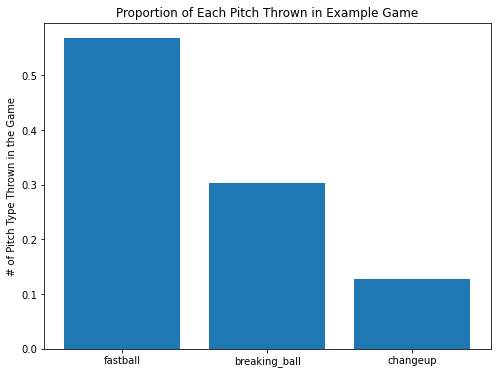

In [161]:
example['pitch'].replace({1: 'changeup', 2: 'breaking_ball', 3: 'fastball'}, inplace=True)

pitch_dist = example['pitch'].value_counts(normalize=True)

plt.figure(figsize=(8,6))
plt.bar(x=pitch_dist.index, height=pitch_dist)
plt.title('Proportion of Each Pitch Thrown in Example Game')
plt.ylabel('# of Pitch Type Thrown in the Game');

## Reading in DataFrame For Entire 2019 Season by the Feature Engineering Function Above

In [162]:
# Loading in clean 2019 season DataFrame
clean_2019 = pd.read_csv('../../clean_2019.csv')

In [163]:
# Looking at the DataFrame head 
clean_2019.head()

,balls,strikes,on_1b,outs_when_up,inning,pitch,changeup_in_sequence,breaking_ball_in_sequence,fastball_in_sequence,proportion_of_breaking_balls_thrown_2018,proportion_of_fastballs_thrown_2018,previous_pitch,previous_zone,previous_hitter_woba,stand_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,risp,run_diff,inning_topbot_Top,previous_type_B,previous_type_S,hitter_woba_2018,average_hitter_launch_speed_2018
0,3.0,2.0,0.0,2.0,9.0,2,0,1,5,0.396482,0.558863,3.0,7.0,0.0,0,1,1,0,0,1,0,4.0,0,0,1,0.366304,90.160819
1,3.0,2.0,0.0,2.0,9.0,3,0,1,4,0.396482,0.558863,3.0,14.0,0.0,0,1,1,0,0,1,0,4.0,0,1,0,0.366304,90.160819
2,2.0,2.0,0.0,2.0,9.0,3,0,1,3,0.396482,0.558863,3.0,9.0,0.0,0,1,1,0,0,1,0,4.0,0,0,1,0.366304,90.160819
3,2.0,1.0,0.0,2.0,9.0,3,0,1,2,0.396482,0.558863,2.0,14.0,0.0,0,1,1,0,0,1,0,4.0,0,1,0,0.366304,90.160819
4,1.0,1.0,0.0,2.0,9.0,2,0,0,2,0.396482,0.558863,3.0,7.0,0.0,0,1,1,0,0,1,0,4.0,0,0,1,0.366304,90.160819


## Determining Number of Null Values and Data Types in Clean Full 2019 DataFrame

In [164]:
clean_2019.isna().sum()

balls                                          0
strikes                                        0
on_1b                                          1
outs_when_up                                   0
inning                                         0
pitch                                          0
changeup_in_sequence                           0
breaking_ball_in_sequence                      0
fastball_in_sequence                           0
proportion_of_breaking_balls_thrown_2018       0
proportion_of_fastballs_thrown_2018            0
previous_pitch                                 1
previous_zone                               3018
previous_hitter_woba                           0
stand_R                                        0
p_throws_R                                     0
if_fielding_alignment_Infield shift            0
if_fielding_alignment_Standard                 0
of_fielding_alignment_4th outfielder           0
of_fielding_alignment_Standard                 0
risp                

In [165]:
clean_2019.shape

(484317, 27)

In [166]:
# Calculating whether it is appropriate to drop all null values

null_previous_zone = 3018
total_observations = 484317

# Observations with null values is such a small portion of the total DataFrame, 
# it is safe to drop the rows containing null previous zones
null_previous_zone / total_observations

0.006231455844002998

In [167]:
clean_2019.dropna(inplace=True)

**I saved the DataFrame created through manipulations above in my s3 bucket to later be used for modeling**

### Pitching Sequence Distributions

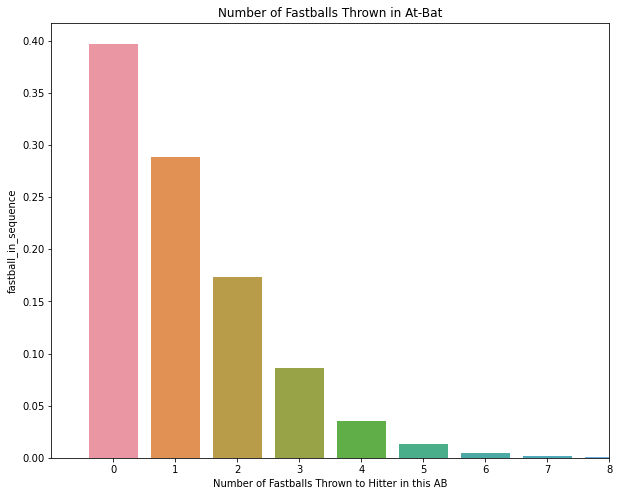

In [193]:
plt.figure(figsize=(10,8))
fastball_sequence_counts = clean_2019['fastball_in_sequence'].value_counts(normalize=True)
sns.barplot(fastball_sequence_counts.index, fastball_sequence_counts)
plt.xlabel('Number of Fastballs Thrown to Hitter in this AB');
plt.title('Number of Fastballs Thrown in At-Bat')
plt.xlim([-1,8]);

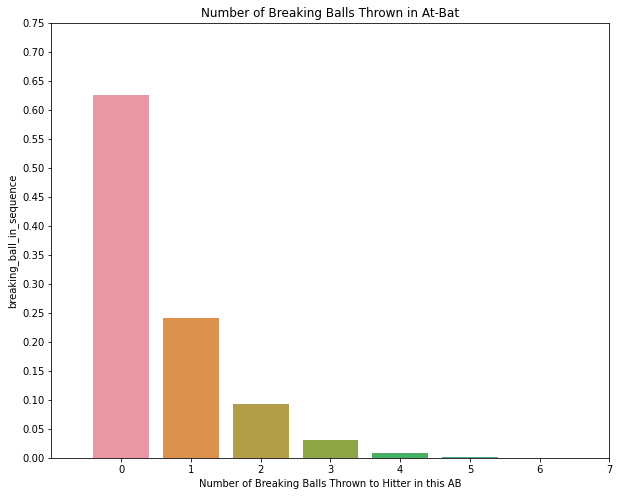

In [194]:
plt.figure(figsize=(10, 8))
breaking_ball_sequence_counts = clean_2019['breaking_ball_in_sequence'].value_counts(normalize=True)
sns.barplot(breaking_ball_sequence_counts.index, breaking_ball_sequence_counts)
plt.yticks(ticks=[np.round(x, 2) for x in np.linspace(0,0.75,16)])
plt.xlabel('Number of Breaking Balls Thrown to Hitter in this AB')
plt.title('Number of Breaking Balls Thrown in At-Bat')
plt.xlim([-1,7]);

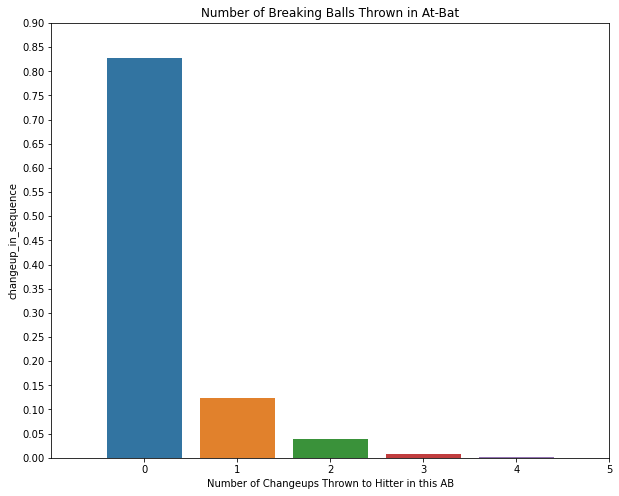

In [195]:
plt.figure(figsize=(10, 8))
changeup_sequence_counts = clean_2019['changeup_in_sequence'].value_counts(normalize=True)
sns.barplot(changeup_sequence_counts.index, changeup_sequence_counts)
sns.barplot(changeup_sequence_counts.index, changeup_sequence_counts)
plt.yticks(ticks=[np.round(x, 2) for x in np.linspace(0,0.9,19)])
plt.xlabel('Number of Changeups Thrown to Hitter in this AB')
plt.title('Number of Breaking Balls Thrown in At-Bat')
plt.xlim([-1,5]);

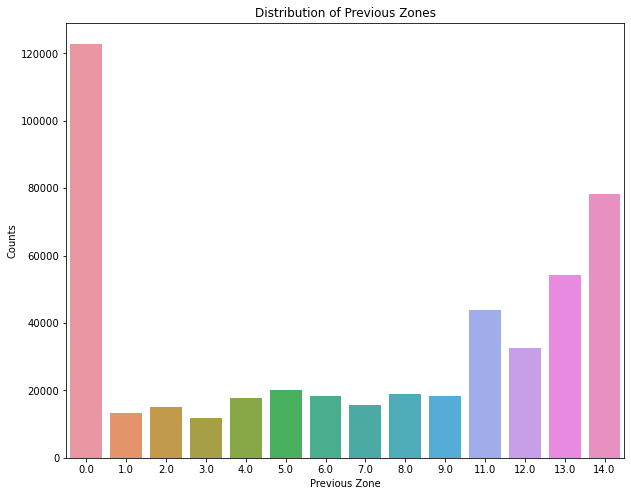

In [172]:
plt.figure(figsize = (10, 8))
sns.barplot(x=clean_2019['previous_zone'].value_counts().index, y=clean_2019['previous_zone'].value_counts())
plt.title('Distribution of Previous Zones')
plt.ylabel('Counts')
plt.xlabel('Previous Zone');

Pitches on the edge of the plate (zones 11, 12, 13, 14) are most common because pitchers are trying to keep the ball from the batter's wheelhouse. 

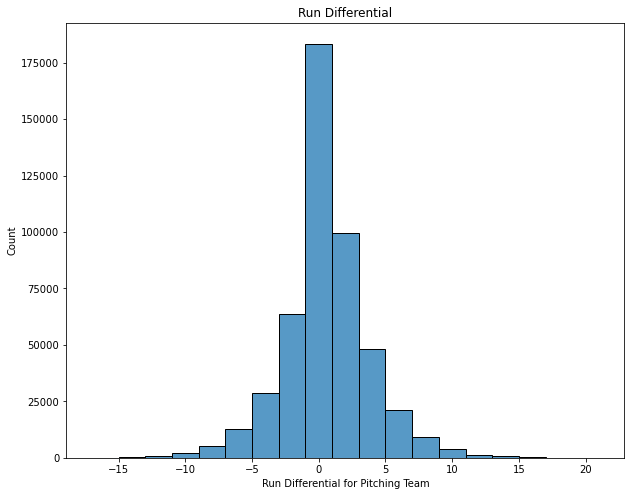

In [173]:
plt.figure(figsize=(10, 8))
sns.histplot(clean_2019['run_diff'], binwidth=2)
plt.xlabel('Run Differential for Pitching Team')
plt.title('Run Differential');

**Analysis: Most pitches occur in games where the pitcher's team is within 1 run of the hitting team.** 

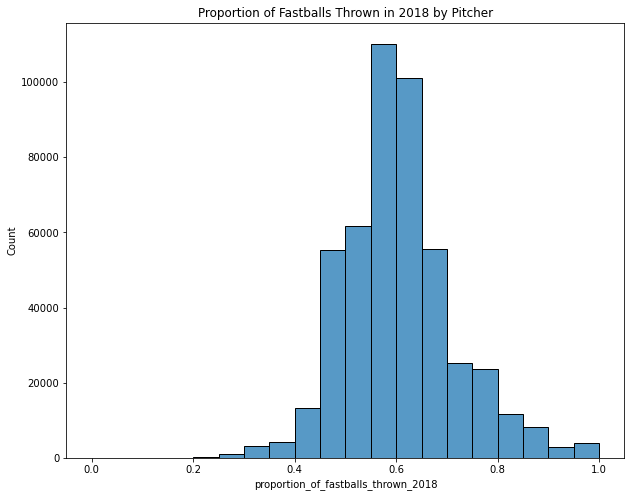

In [174]:
plt.figure(figsize=(10, 8))
sns.histplot(clean_2019['proportion_of_fastballs_thrown_2018'], binwidth=0.05)
plt.title('Proportion of Fastballs Thrown in 2018 by Pitcher');

The proportion of fastballs thrown by pitchers in the 2017 season is normally distributed around 60% of the total pitches thrown. 

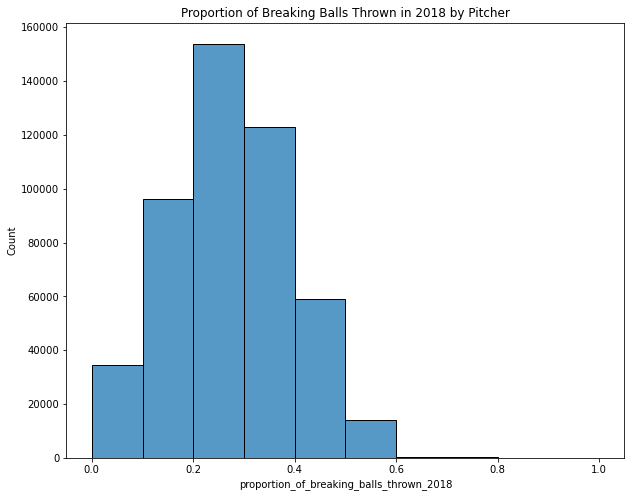

In [175]:
plt.figure(figsize=(10, 8))
sns.histplot(clean_2019['proportion_of_breaking_balls_thrown_2018'], bins=10)
plt.title('Proportion of Breaking Balls Thrown in 2018 by Pitcher');

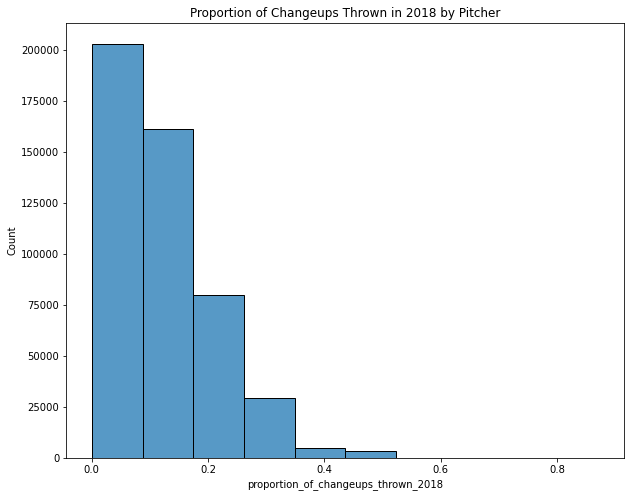

In [176]:
plt.figure(figsize=(10, 8))

sns.histplot(1-(clean_2019['proportion_of_breaking_balls_thrown_2018'] + 
             clean_2019['proportion_of_fastballs_thrown_2018']), bins=10)
plt.xlabel('proportion_of_changeups_thrown_2018')

plt.title('Proportion of Changeups Thrown in 2018 by Pitcher');

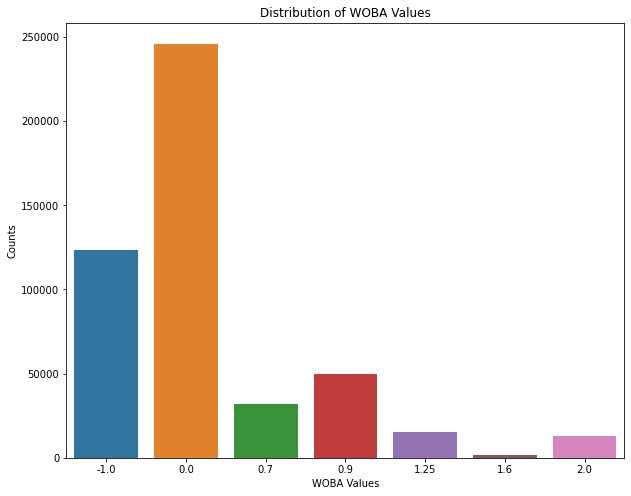

In [177]:
#previous_hitter_woba_counts = clean_2019['previous_hitter_woba'].value_counts()
plt.figure(figsize = (10, 8))
# clean_2019['previous_hitter_woba'].value_counts()
sns.barplot(x = clean_2019['previous_hitter_woba'].value_counts().index, y =clean_2019['previous_hitter_woba'].value_counts() )
plt.title('Distribution of WOBA Values')
plt.ylabel('Counts')
plt.xlabel('WOBA Values');

I decided to drop the previous hitter's woba after noticing some inconsistencies throughout the data post feature-engineering. Overall, I do not think this will impact the quality of my model too much because pitchers at the professional level will not be easily influenced by the previous at-bat. In the future, I would like to evaluate where the feature-engineering went wrong and attempt to fix the issue in order to double-check this hunch.

In [178]:
clean_2019 = clean_2019.drop(columns=['previous_hitter_woba'])

## Summary Statistics of the DataFrame

In [179]:
clean_2019.describe()

,balls,strikes,on_1b,outs_when_up,inning,pitch,changeup_in_sequence,breaking_ball_in_sequence,fastball_in_sequence,proportion_of_breaking_balls_thrown_2018,proportion_of_fastballs_thrown_2018,previous_pitch,previous_zone,stand_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,risp,run_diff,inning_topbot_Top,previous_type_B,previous_type_S,hitter_woba_2018,average_hitter_launch_speed_2018
count,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000
mean,0.896939,0.897554,0.300819,0.978406,5.011299,2.454769,0.237715,0.562972,1.140761,0.276236,0.606737,1.830513,7.192851,0.576008,0.726673,0.285991,0.627491,0.001199,0.907482,0.229568,0.120482,0.507219,0.340830,0.403811,0.336888,88.802143
std,0.974362,0.827266,0.458615,0.818402,2.710171,0.712127,0.588605,0.878292,1.268931,0.119572,0.109596,1.233575,5.528769,0.494190,0.445668,0.451885,0.483473,0.034604,0.289757,0.420556,3.209411,0.499948,0.473989,0.490661,0.037657,2.161338
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.000000,0.000000,0.000000,0.000000,0.208013,80.540385
25%,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.191111,0.535912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.313768,87.297129
50%,1.000000,1.000000,0.000000,1.000000,5.000000,3.000000,0.000000,0.000000,1.000000,0.274366,0.597463,2.000000,8.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.336937,88.866857
75%,2.000000,2.000000,1.000000,2.000000,7.000000,3.000000,0.000000,1.000000,2.000000,0.361502,0.663443,3.000000,13.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.361044,90.302941
max,4.000000,2.000000,1.000000,2.000000,19.000000,3.000000,9.000000,10.000000,11.000000,1.000000,1.000000,3.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,1.000000,1.000000,1.000000,0.452487,94.955674


### Analysis

* Overall the summary statistics paint a picture of the data being reliable. While it is clear that my feature-engineering function needed to be more modular, that is a project I will take on post-course. 

* There are no outliers that stand out to me other than potentially the max number of pitches thrown in a sequence. I will analyze each below to ensure that the number of pitches in the sequence makes sense. 

In [180]:
# The chageup thrown 9 times in one at-bat makes sense given the count and the 
# pitcher's pitch distribution
clean_2019[clean_2019['changeup_in_sequence'] == 9]

,balls,strikes,on_1b,outs_when_up,inning,pitch,changeup_in_sequence,breaking_ball_in_sequence,fastball_in_sequence,proportion_of_breaking_balls_thrown_2018,proportion_of_fastballs_thrown_2018,previous_pitch,previous_zone,stand_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,risp,run_diff,inning_topbot_Top,previous_type_B,previous_type_S,hitter_woba_2018,average_hitter_launch_speed_2018
170547,2.0,2.0,0.0,1.0,7.0,3,9,0,1,0.074663,0.477356,1.0,13.0,1,1,1,0,0,1,1,-6.0,0,1,0,0.353141,89.901344


## Creating Binary DataFrame

In [181]:
# Creating binary 2019 DataFrame with copy of clean_2019
clean_2019_binary = clean_2019.copy()

In [182]:
# Making the binary pitch labels. 0 is offspeed (change-up and breaking ball)
# while 1 denotes fastball
clean_2019_binary['pitch'] = [0 if x in [1,2] else 1 for x in clean_2019_binary['pitch']]

In [183]:
# Double checking the value counts
clean_2019_binary['pitch'].value_counts(normalize=True)

1    0.584354
0    0.415646
Name: pitch, dtype: float64

In [184]:
# Adding together a pitcher's 2017 offspeed and fastball proportions
clean_2019_binary['offspeed_in_sequence'] = clean_2019_binary['changeup_in_sequence'] \
+ clean_2019_binary['breaking_ball_in_sequence']

# Dropping columns that were combined to make new offspeed feature and 
# dropping proportion of breaking balls thrown to make pitcher distribution to make
# DataFrame rank efficient
clean_2019_binary = clean_2019_binary.drop(columns=['changeup_in_sequence', 
                                                    'breaking_ball_in_sequence', 
                                                   'proportion_of_breaking_balls_thrown_2018'])

In [185]:
# Combining the changeup and breaking ball pitches, re-labeling previous pitch 
# not occuring in the same inning/game/pitcher to 3
clean_2019_binary['previous_pitch'] = [0 if x in [1,2] else 1 if x == 3 else 3 
                                       for x in clean_2019_binary['previous_pitch']]

In [186]:
# Value count of previous pitches. AGain, I would make a new feature to denote 
# whether these values should be considered rather than trying to create a new value
clean_2019_binary['previous_pitch'].value_counts()

1    209419
0    148976
3    122904
Name: previous_pitch, dtype: int64

In [187]:
clean_2019_binary.head()

,balls,strikes,on_1b,outs_when_up,inning,pitch,fastball_in_sequence,proportion_of_fastballs_thrown_2018,previous_pitch,previous_zone,stand_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,risp,run_diff,inning_topbot_Top,previous_type_B,previous_type_S,hitter_woba_2018,average_hitter_launch_speed_2018,offspeed_in_sequence
0,3.0,2.0,0.0,2.0,9.0,0,5,0.558863,1,7.0,0,1,1,0,0,1,0,4.0,0,0,1,0.366304,90.160819,1
1,3.0,2.0,0.0,2.0,9.0,1,4,0.558863,1,14.0,0,1,1,0,0,1,0,4.0,0,1,0,0.366304,90.160819,1
2,2.0,2.0,0.0,2.0,9.0,1,3,0.558863,1,9.0,0,1,1,0,0,1,0,4.0,0,0,1,0.366304,90.160819,1
3,2.0,1.0,0.0,2.0,9.0,1,2,0.558863,0,14.0,0,1,1,0,0,1,0,4.0,0,1,0,0.366304,90.160819,1
4,1.0,1.0,0.0,2.0,9.0,0,2,0.558863,1,7.0,0,1,1,0,0,1,0,4.0,0,0,1,0.366304,90.160819,0


In [188]:
clean_2019_binary.describe()

,balls,strikes,on_1b,outs_when_up,inning,pitch,fastball_in_sequence,proportion_of_fastballs_thrown_2018,previous_pitch,previous_zone,stand_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,risp,run_diff,inning_topbot_Top,previous_type_B,previous_type_S,hitter_woba_2018,average_hitter_launch_speed_2018,offspeed_in_sequence
count,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000,481299.000000
mean,0.896939,0.897554,0.300819,0.978406,5.011299,0.584354,1.140761,0.606737,1.201189,7.192851,0.576008,0.726673,0.285991,0.627491,0.001199,0.907482,0.229568,0.120482,0.507219,0.340830,0.403811,0.336888,88.802143,0.800687
std,0.974362,0.827266,0.458615,0.818402,2.710171,0.492834,1.268931,0.109596,1.135998,5.528769,0.494190,0.445668,0.451885,0.483473,0.034604,0.289757,0.420556,3.209411,0.499948,0.473989,0.490661,0.037657,2.161338,1.048321
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.000000,0.000000,0.000000,0.000000,0.208013,80.540385,0.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.535912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.313768,87.297129,0.000000
50%,1.000000,1.000000,0.000000,1.000000,5.000000,1.000000,1.000000,0.597463,1.000000,8.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.336937,88.866857,0.000000
75%,2.000000,2.000000,1.000000,2.000000,7.000000,1.000000,2.000000,0.663443,3.000000,13.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.361044,90.302941,1.000000
max,4.000000,2.000000,1.000000,2.000000,19.000000,1.000000,11.000000,1.000000,3.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,1.000000,1.000000,1.000000,0.452487,94.955674,10.000000


## Baseline Accuracy

fastball         0.584354
breaking_ball    0.286061
changeup         0.129585
Name: pitch, dtype: float64


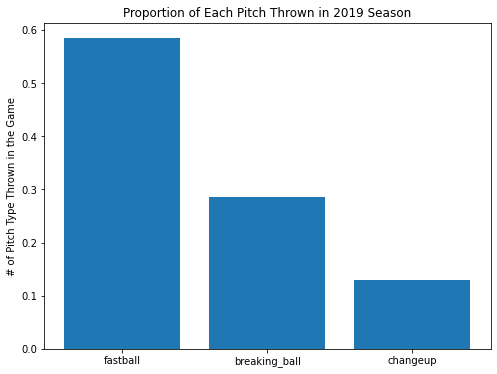

In [196]:
# Plotting total proportion of each pitch in 2018 season
clean_2019['pitch'].replace({1: 'changeup', 2: 'breaking_ball', 3: 'fastball'}, inplace=True)

pitch_dist = clean_2019['pitch'].value_counts(normalize=True)
print(pitch_dist)

plt.figure(figsize=(8,6))
plt.bar(x=pitch_dist.index, height=pitch_dist)
plt.title('Proportion of Each Pitch Thrown in 2019 Season')
plt.ylabel('# of Pitch Type Thrown in the Game');

In [190]:
clean_2019['pitch'].value_counts(normalize=True)

fastball         0.584354
breaking_ball    0.286061
changeup         0.129585
Name: pitch, dtype: float64

**To beat the baseline, I need to have an accuracy higher than 58.4% for multiclass classification**

fastball    0.584354
offspeed    0.415646
Name: pitch, dtype: float64


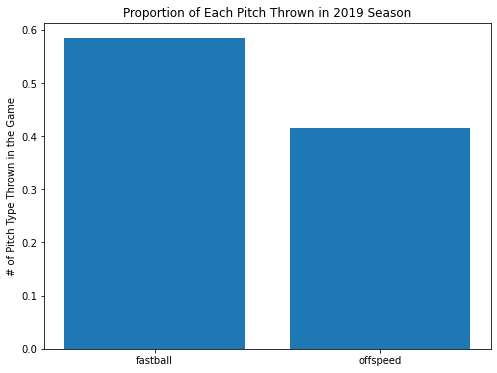

In [197]:
# Plotting total proportion of binary pitch type (fastball, offspeed) in 2018 
clean_2019_binary['pitch'].replace({0:'offspeed', 1: 'fastball'}, inplace=True)

pitch_dist = clean_2019_binary['pitch'].value_counts(normalize=True)
print(pitch_dist)

plt.figure(figsize=(8,6))
plt.bar(x=pitch_dist.index, height=pitch_dist)
plt.title('Proportion of Each Pitch Thrown in 2019 Season')
plt.ylabel('# of Pitch Type Thrown in the Game');

In [192]:
clean_2019_binary['pitch'].value_counts(normalize=True)

fastball    0.584354
offspeed    0.415646
Name: pitch, dtype: float64